In [30]:
import pandas as pd
import os
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from xgboost import plot_importance
from xgboost import plot_tree

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, mean_squared_error


from sklearn.metrics import  mean_squared_error

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


import warnings
warnings.filterwarnings('ignore')

# 1. Loading and Building Dataset

In [2]:
# Define the path where datasets are stored
project_path = r"C:\Workspace\AIN-313\Project\NBA_Shots_04_24"  


# List all CSV files in the project path
file_list = [f for f in os.listdir(project_path) if f.endswith('.csv') and 'NBA_' in f]

# Initialize an empty list to hold dataframes
dataframes = []

# Load each file into a dataframe
for file_name in sorted(file_list):  # Sort files to maintain chronological order
    file_path = os.path.join(project_path, file_name)
    df = pd.read_csv(file_path)
    print(f"Loaded {file_name} with shape {df.shape}")
    dataframes.append(df)

# Merge all dataframes into one
merged_df = pd.concat(dataframes, ignore_index=True)

# Display the shape and a preview of the merged dataframe
print(f"\nMerged dataset shape: {merged_df.shape}")
print("\n Merged Dataset Head: ")
merged_df.head()

Loaded NBA_2004_Shots.csv with shape (189803, 26)
Loaded NBA_2005_Shots.csv with shape (197626, 26)
Loaded NBA_2006_Shots.csv with shape (194314, 26)
Loaded NBA_2007_Shots.csv with shape (196072, 26)
Loaded NBA_2008_Shots.csv with shape (200501, 26)
Loaded NBA_2009_Shots.csv with shape (199030, 26)
Loaded NBA_2010_Shots.csv with shape (200966, 26)
Loaded NBA_2011_Shots.csv with shape (199761, 26)
Loaded NBA_2012_Shots.csv with shape (161205, 26)
Loaded NBA_2013_Shots.csv with shape (201579, 26)
Loaded NBA_2014_Shots.csv with shape (204126, 26)
Loaded NBA_2015_Shots.csv with shape (205550, 26)
Loaded NBA_2016_Shots.csv with shape (207893, 26)
Loaded NBA_2017_Shots.csv with shape (209929, 26)
Loaded NBA_2018_Shots.csv with shape (211707, 26)
Loaded NBA_2019_Shots.csv with shape (219458, 26)
Loaded NBA_2020_Shots.csv with shape (188116, 26)
Loaded NBA_2021_Shots.csv with shape (190983, 26)
Loaded NBA_2022_Shots.csv with shape (216722, 26)
Loaded NBA_2023_Shots.csv with shape (217220, 26)


,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,BASIC_ZONE,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
0,2004,2003-04,1610612747,Los Angeles Lakers,977,Kobe Bryant,G,SG,04-14-2004,20301187,...,Above the Break 3,Left Side Center,LC,24+ ft.,20.0,21.35,25,6,0,0
1,2004,2003-04,1610612757,Portland Trail Blazers,757,Damon Stoudamire,G,PG,04-14-2004,20301187,...,Restricted Area,Center,C,Less Than 8 ft.,-0.0,5.25,0,6,0,2
2,2004,2003-04,1610612747,Los Angeles Lakers,977,Kobe Bryant,G,SG,04-14-2004,20301187,...,Mid-Range,Left Side Center,LC,16-24 ft.,13.3,24.45,23,6,0,9
3,2004,2003-04,1610612757,Portland Trail Blazers,757,Damon Stoudamire,G,PG,04-14-2004,20301187,...,Mid-Range,Left Side,L,16-24 ft.,16.4,13.95,18,6,0,31
4,2004,2003-04,1610612757,Portland Trail Blazers,757,Damon Stoudamire,G,PG,04-14-2004,20301187,...,Mid-Range,Right Side,R,16-24 ft.,-15.8,7.85,16,6,0,55


**Since we'll focus on LeBron James, I am going to build a seperate dataframe of his logs**

In [3]:
# Filter rows where PLAYER_NAME is "LeBron James"
lebron_df = merged_df[merged_df['PLAYER_NAME'] == 'LeBron James']

# Display the shape and a preview of the filtered dataset
print(f"LeBron James' shots dataset shape: {lebron_df.shape}")
lebron_df.head(5)


LeBron James' shots dataset shape: (29311, 26)


,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,BASIC_ZONE,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
258,2004,2003-04,1610612739,Cleveland Cavaliers,2544,LeBron James,G,SG,04-14-2004,20301179,...,Restricted Area,Center,C,Less Than 8 ft.,-0.0,5.25,0,4,0,30
307,2004,2003-04,1610612739,Cleveland Cavaliers,2544,LeBron James,G,SG,04-14-2004,20301179,...,Restricted Area,Center,C,Less Than 8 ft.,-0.0,5.25,0,4,1,20
431,2004,2003-04,1610612739,Cleveland Cavaliers,2544,LeBron James,G,SG,04-14-2004,20301179,...,Above the Break 3,Left Side Center,LC,24+ ft.,21.0,20.35,25,4,5,5
570,2004,2003-04,1610612739,Cleveland Cavaliers,2544,LeBron James,G,SG,04-14-2004,20301179,...,Restricted Area,Center,C,Less Than 8 ft.,-0.0,5.25,0,4,8,56
632,2004,2003-04,1610612739,Cleveland Cavaliers,2544,LeBron James,G,SG,04-14-2004,20301179,...,Restricted Area,Center,C,Less Than 8 ft.,-0.0,5.25,0,4,10,55


**We have 29311 shot logs. I think that's enough for a proper model train**

# 2. Data Exploration

## 2.1 Basic Information

In [4]:
# Column names and data types
print(lebron_df.info())

# Check for missing values
lebron_df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
Index: 29311 entries, 258 to 4135774
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SEASON_1        29311 non-null  int64  
 1   SEASON_2        29311 non-null  object 
 2   TEAM_ID         29311 non-null  int64  
 3   TEAM_NAME       29311 non-null  object 
 4   PLAYER_ID       29311 non-null  int64  
 5   PLAYER_NAME     29311 non-null  object 
 6   POSITION_GROUP  29311 non-null  object 
 7   POSITION        29311 non-null  object 
 8   GAME_DATE       29311 non-null  object 
 9   GAME_ID         29311 non-null  int64  
 10  HOME_TEAM       29311 non-null  object 
 11  AWAY_TEAM       29311 non-null  object 
 12  EVENT_TYPE      29311 non-null  object 
 13  SHOT_MADE       29311 non-null  bool   
 14  ACTION_TYPE     29311 non-null  object 
 15  SHOT_TYPE       29311 non-null  object 
 16  BASIC_ZONE      29311 non-null  object 
 17  ZONE_NAME       29311 non-null  

SEASON_1          0
SEASON_2          0
TEAM_ID           0
TEAM_NAME         0
PLAYER_ID         0
PLAYER_NAME       0
POSITION_GROUP    0
POSITION          0
GAME_DATE         0
GAME_ID           0
HOME_TEAM         0
AWAY_TEAM         0
EVENT_TYPE        0
SHOT_MADE         0
ACTION_TYPE       0
SHOT_TYPE         0
BASIC_ZONE        0
ZONE_NAME         0
ZONE_ABB          0
ZONE_RANGE        0
LOC_X             0
LOC_Y             0
SHOT_DISTANCE     0
QUARTER           0
MINS_LEFT         0
SECS_LEFT         0
dtype: int64

In [5]:
# Since I'll work with that dataframe for a while, for better usage I changed it name to "df" and copied the df for any case
df = lebron_df.copy()     

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29311 entries, 258 to 4135774
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SEASON_1        29311 non-null  int64  
 1   SEASON_2        29311 non-null  object 
 2   TEAM_ID         29311 non-null  int64  
 3   TEAM_NAME       29311 non-null  object 
 4   PLAYER_ID       29311 non-null  int64  
 5   PLAYER_NAME     29311 non-null  object 
 6   POSITION_GROUP  29311 non-null  object 
 7   POSITION        29311 non-null  object 
 8   GAME_DATE       29311 non-null  object 
 9   GAME_ID         29311 non-null  int64  
 10  HOME_TEAM       29311 non-null  object 
 11  AWAY_TEAM       29311 non-null  object 
 12  EVENT_TYPE      29311 non-null  object 
 13  SHOT_MADE       29311 non-null  bool   
 14  ACTION_TYPE     29311 non-null  object 
 15  SHOT_TYPE       29311 non-null  object 
 16  BASIC_ZONE      29311 non-null  object 
 17  ZONE_NAME       29311 non-null  

## 2.2 Descriptive Statistics

In [7]:
# Summary statistics for numerical columns
print(df.describe())

# Unique values in categorical columns
categorical_cols = ['TEAM_NAME', 'PLAYER_NAME', 'EVENT_TYPE', 'ACTION_TYPE', 'SHOT_TYPE']
for col in categorical_cols:
    print(f"Unique values in {col}: {df[col].unique()}")


           SEASON_1       TEAM_ID  PLAYER_ID       GAME_ID         LOC_X  \
count  29311.000000  2.931100e+04    29311.0  2.931100e+04  29311.000000   
mean    2013.275289  1.610613e+09     2544.0  2.122812e+07      0.777706   
std        6.048507  4.175265e+00        0.0  6.048328e+05      9.753958   
min     2004.000000  1.610613e+09     2544.0  2.030001e+07    -24.800000   
25%     2008.000000  1.610613e+09     2544.0  2.070056e+07     -1.800000   
50%     2013.000000  1.610613e+09     2544.0  2.120051e+07      0.000000   
75%     2018.000000  1.610613e+09     2544.0  2.170095e+07      4.350000   
max     2024.000000  1.610613e+09     2544.0  2.230123e+07     24.800000   

              LOC_Y  SHOT_DISTANCE       QUARTER     MINS_LEFT     SECS_LEFT  
count  29311.000000   29311.000000  29311.000000  29311.000000  29311.000000  
mean      12.314599      11.708744      2.513561      5.044352     28.290676  
std        8.716522      10.336964      1.152725      3.458327     17.593051  

## 2.3 Data Visualization

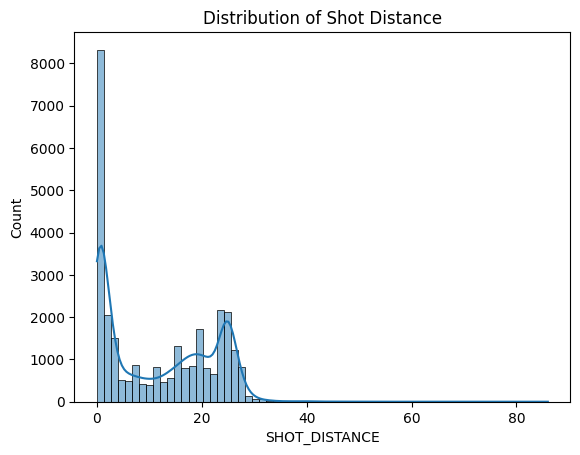

In [8]:
# Distribution of shot distances
sns.histplot(df['SHOT_DISTANCE'], kde=True)
plt.title("Distribution of Shot Distance")
plt.show()

**Distribution of Shot Distance**

Description: This histogram shows the distribution of shot distances, overlaid with a KDE curve. Most shots are concentrated near 0 to 10 feet, with frequencies dropping significantly as distance increases.

Insights:
A significant majority of shots are taken close to the basket, which aligns with the NBA's emphasis on high-percentage shots like layups and dunks.

There's a small secondary peak around the three-point range (~23-25 feet), highlighting the popularity of three-point shooting in the league.

Outliers beyond 40 feet could represent desperation shots at the end of quarters.

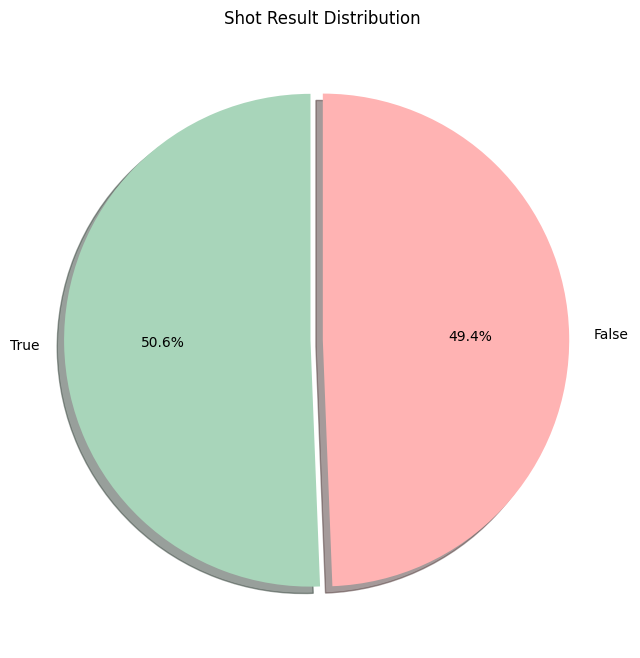

In [9]:
# pie chart
counts = df['SHOT_MADE'].value_counts()

# percentages
percentages = counts / counts.sum() * 100
colors = ['#A8D5BA', '#FFB3B3']  # Pastel tons that I found on web

plt.figure(figsize=(8, 8))
plt.pie(
    percentages,
    labels=percentages.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    shadow=True,  # Shadow effect that I learned from a video-
    explode=[0.05, 0],)  # 3D effect for cosmetic purposes
plt.title('Shot Result Distribution')
plt.show()

**Shot Result Distribution**

Description: The pie chart shows a near 50-50 distribution of successful (True) and unsuccessful (False) shots, with a slight tilt toward successful shots at 50.6%.

Insights:
The close split suggests a well-balanced dataset, which is excellent for analysis.

The success rate near 50% reflects the general field goal efficiency in professional basketball, especially when considering a mix of shot types and distances.

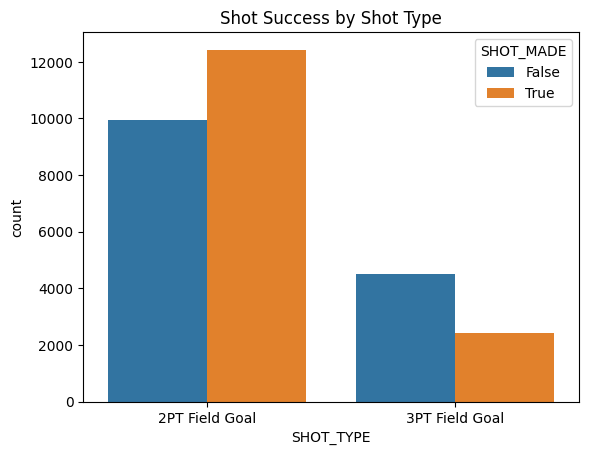

In [10]:
# Shot success by shot type
sns.countplot(x='SHOT_TYPE', hue='SHOT_MADE', data=df)
plt.title("Shot Success by Shot Type")
plt.show()


**Shot Success by Shot Type**
Description: A bar chart displaying shot success rates for two-point field goals and three-point field goals.

Insights:
Two-point field goals have a significantly higher success rate than three-point field goals, which is consistent with real-world basketball trends.

The lower success rate for three-point attempts is offset by their higher scoring value.

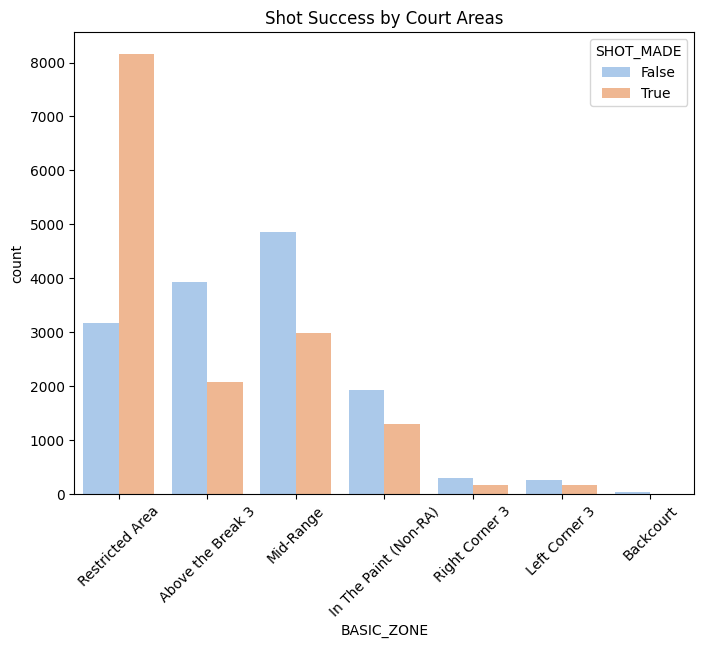

In [11]:
# Distribution of shot success by court areas
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='BASIC_ZONE', hue='SHOT_MADE', palette='pastel')
plt.title("Shot Success by Court Areas")
plt.xticks(rotation=45)
plt.show()

**Shot Success by Court Areas**

Description: A bar chart visualizing the success rate of shots across different court zones.

Insights:
Restricted Area sees the highest number of successful shots, aligning with the efficiency of shots close to the basket.

Zones like Above the Break 3 and Mid-Range have more unsuccessful attempts, likely due to increased difficulty and lower efficiency.


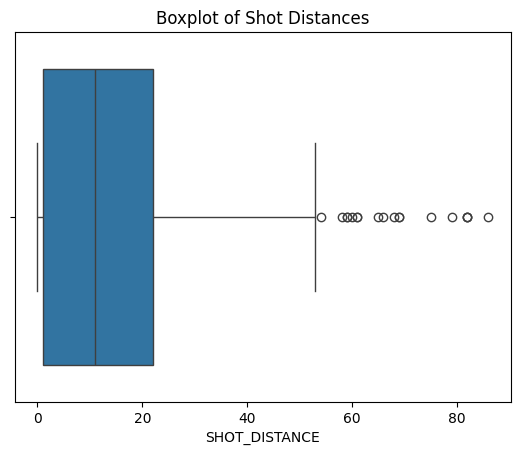

In [12]:
# Boxplot for shot distances
sns.boxplot(x='SHOT_DISTANCE', data=lebron_df)
plt.title("Boxplot of Shot Distances")
plt.show()

**Boxplot of Shot Distances**

Description: A boxplot summarizing the spread of shot distances.

Insights:
The interquartile range (IQR) of shot distances is tightly concentrated below 20 feet, reflecting the predominance of close-range shots.

Several outliers are evident, likely representing half-court and buzzer-beater attempts.


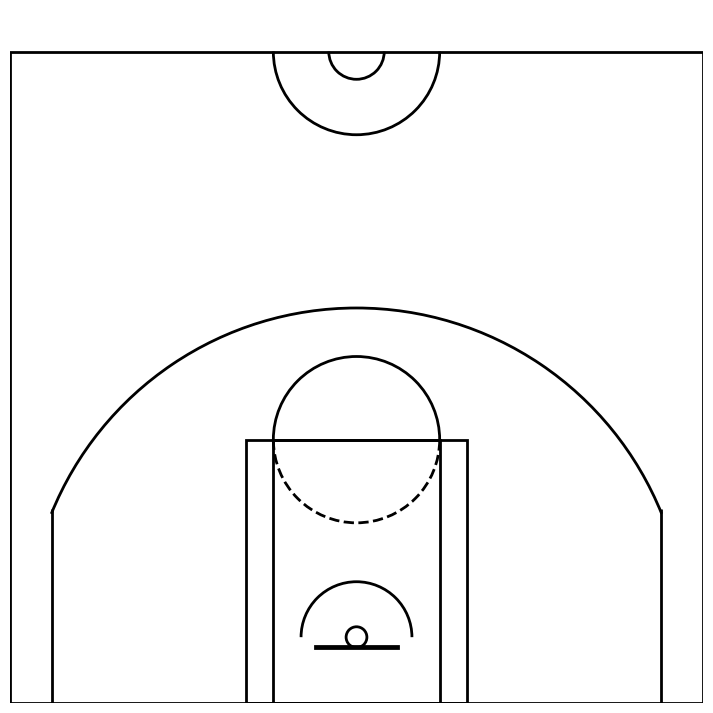

In [13]:
# This draw is originally from a github user. It drawed in a different scale and in R language. I tried to rescale it and convert it to python
# It really took time, I tried so hard to fit my dataset. I gave my hours but in the end I made it. It is the most valnurable precious and usefull plot
# Finding the Scaling coefficients was really hard...  
def draw_scaled_court(ax=None, color='black', lw=2):
    if ax is None:
        ax = plt.gca()
    
    # Court Sizes (Scaled version, for inch dimensions)
    width = 50  # Court width (half-court: 25)
    height = 47  # Court length (half-court: 47, full-court: 94)
    
    # Painted area
    outer_box = Rectangle((-8, 0), 16, 19, linewidth=lw, color=color, fill=False)
    inner_box = Rectangle((-6, 0), 12, 19, linewidth=lw, color=color, fill=False)
    
    # Arc (Free throw arcs)
    top_free_throw = Arc((0, 19), 12, 12, theta1=0, theta2=180, linewidth=lw, color=color)
    bottom_free_throw = Arc((0, 19), 12, 12, theta1=180, theta2=0, linewidth=lw, color=color, linestyle='dashed')
    
    # Hoop circle
    hoop = Circle((0, 4.75), radius=0.75, linewidth=lw, color=color, fill=False)
    
    # Backboard
    backboard = Rectangle((-3, 4), 6, 0.1, linewidth=lw, color=color, fill=True)
    
    # Restricted zone
    restricted_zone = Arc((0, 4.75), 8, 8, theta1=0, theta2=180, linewidth=lw, color=color)
    
    # Three-point line
    corner_three_a = Rectangle((-22, 0), 0, 14, linewidth=lw, color=color)
    corner_three_b = Rectangle((22, 0), 0, 14, linewidth=lw, color=color)
    three_arc = Arc((0, 4.75), 47.5, 47.5, theta1=22, theta2=158, linewidth=lw, color=color)
    
    # Half-court line and arcs
    center_outer_arc = Arc((0, 47), 12, 12, theta1=180, theta2=0, linewidth=lw, color=color)
    center_inner_arc = Arc((0, 47), 4, 4, theta1=180, theta2=0, linewidth=lw, color=color)
    
    # Court boundaries
    outer_lines = Rectangle((-25, 0), 50, 47, linewidth=lw, color=color, fill=False)
    
    # Add court elements
    court_elements = [outer_box, inner_box, top_free_throw, bottom_free_throw, hoop,
                      backboard, restricted_zone, corner_three_a, corner_three_b, three_arc,
                      center_outer_arc, center_inner_arc, outer_lines]
    
    for element in court_elements:
        ax.add_patch(element)
    
    # Adjust axes
    ax.set_xlim(-25, 25)
    ax.set_ylim(0, 50)
    ax.set_aspect(1)
    ax.axis('off')  # Hide axis labels

# Draw the court
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(1, 1, 1)
draw_scaled_court(ax)
plt.show()

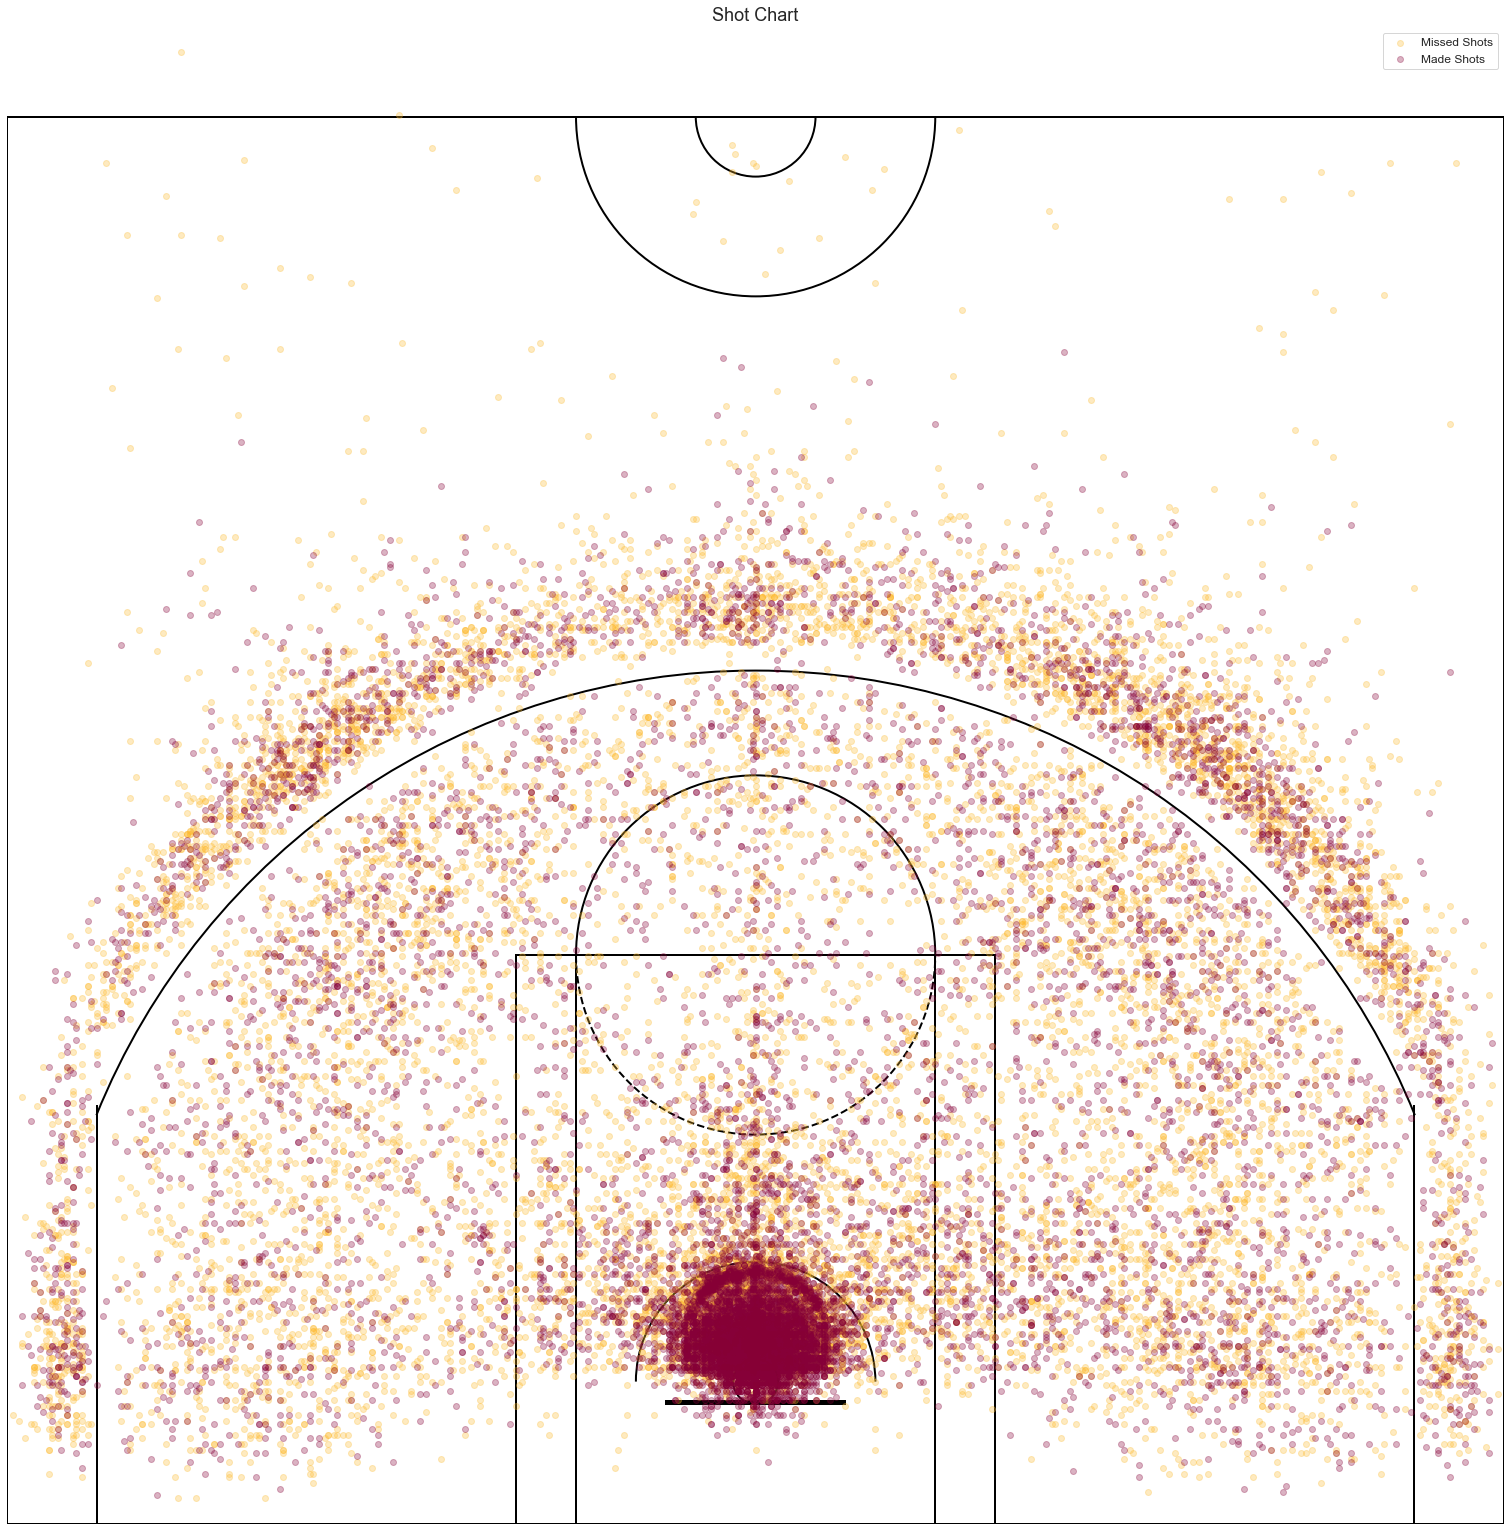

In [14]:
# Printing the court with shots
sns.set_style("white")
sns.set_color_codes()

all_shot_fig = plt.figure(figsize=(30, 27), dpi=72)
all_shot_ax = all_shot_fig.add_subplot(111)

# Court Dimensions
all_shot_ax.set_ylim([0, 50])
all_shot_ax.set_xlim([-25, 25])

# Drawing the court
draw_scaled_court(ax=all_shot_ax, color='black', lw=2)

# Missed Shots
all_shot_ax.scatter(
    df[df.EVENT_TYPE == "Missed Shot"].LOC_X,
    df[df.EVENT_TYPE == "Missed Shot"].LOC_Y,
    color='#FDBB30', alpha=0.3, label='Missed Shots'
)

# Made Shots
all_shot_ax.scatter(
    df[df.EVENT_TYPE == "Made Shot"].LOC_X,
    df[df.EVENT_TYPE == "Made Shot"].LOC_Y,
    color='#860038', alpha=0.3, label='Made Shots'
)

# Title
all_shot_ax.set_title('Shot Chart', fontsize=18)
all_shot_ax.set_xlabel('Court X', fontsize=14)
all_shot_ax.set_ylabel('Court Y', fontsize=14)

all_shot_ax.legend(loc='upper right', fontsize=12)

plt.show()

**Insights:**

1. Close-Range Dominance:

The chart shows a significant density of shot attempts near the basket, with both made (red dots) and missed (yellow dots) shots concentrated in this area.
This reflects LeBron’s well-known ability to attack the rim throughout his career. His combination of size, speed, and strength has consistently allowed him to generate high-percentage looks in the restricted zone.
For predictive modeling, this area could represent a feature for scoring efficiency or highlight how shot outcomes depend on distance from the basket.

2. Three-Point Evolution:

The three-point arc has a consistent spread of attempts, especially from the corners and the top of the key. This aligns with LeBron’s improved three-point shooting over the years, particularly as the NBA has increasingly prioritized the three-point shot.

3. Mid-Range Decline:

The mid-range zone (between the paint and three-point arc) shows relatively fewer shot attempts compared to close-range and three-pointers.
This aligns with the league-wide trend of reducing mid-range attempts due to their lower scoring efficiency compared to three-point shots and layups/dunks.

4. Missed vs. Made Shots:

Missed shots are spread across the court, particularly further from the basket. This indicates that contested or long-range shots have a lower probability of success compared to shots near the rim or from efficient three-point spots.
Made shots are clustered near the basket and around high-efficiency areas on the three-point arc, showcasing LeBron’s ability to maximize scoring opportunities in optimal locations.
Including "shot type" or "shot location" as features in our model could help differentiate high-probability zones from areas where misses are more likely.

5. The Paint as a Core Zone:

The paint area (restricted zone and surrounding key) is a central feature of LeBron's game, with frequent attempts and a mix of results.
Over time, his reliance on the paint has likely shifted as his three-point shooting improved and his role in teams evolved. Capturing temporal trends in this area could provide valuable input for modeling his shot behavior.

6. Three-Point Corners:

The corners of the three-point arc show a distinct density of attempts. These spots are efficient areas for three-point shooting due to the shorter distance to the basket.

7. Top of the Key Activity:

The consistent activity at the top of the three-point arc reflects LeBron’s role in initiating plays and pulling up for shots or stepping into open threes in transition.

In [15]:
df.columns

Index(['SEASON_1', 'SEASON_2', 'TEAM_ID', 'TEAM_NAME', 'PLAYER_ID',
       'PLAYER_NAME', 'POSITION_GROUP', 'POSITION', 'GAME_DATE', 'GAME_ID',
       'HOME_TEAM', 'AWAY_TEAM', 'EVENT_TYPE', 'SHOT_MADE', 'ACTION_TYPE',
       'SHOT_TYPE', 'BASIC_ZONE', 'ZONE_NAME', 'ZONE_ABB', 'ZONE_RANGE',
       'LOC_X', 'LOC_Y', 'SHOT_DISTANCE', 'QUARTER', 'MINS_LEFT', 'SECS_LEFT'],
      dtype='object')

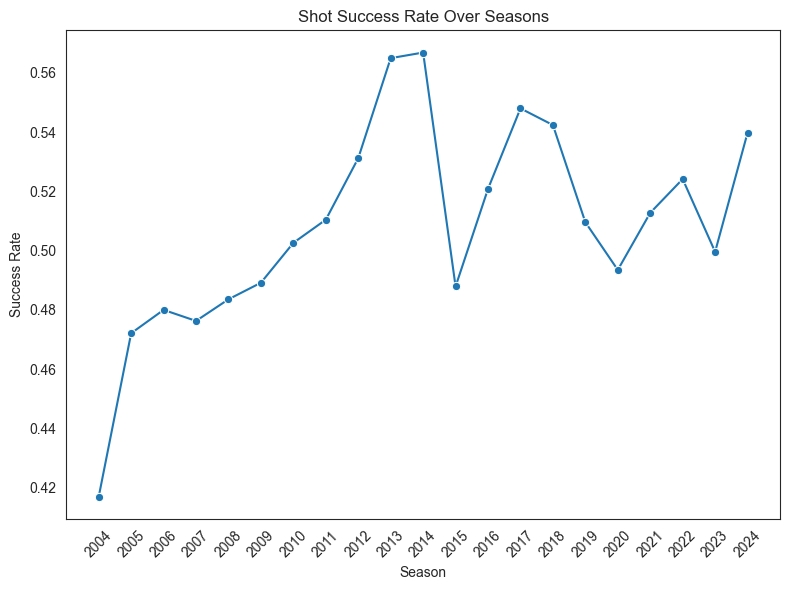

In [16]:
if 'SEASON_1' in df.columns:
    plt.figure(figsize=(8, 6))
    # Converting season column to string type if not already
    df['SEASON_1'] = df['SEASON_1'].astype(str)
    
    # Calculate success rate per season
    season_success_rate = df.groupby('SEASON_1')['SHOT_MADE'].mean()
    
    # Plot with clear season labels
    sns.lineplot(x=season_success_rate.index, y=season_success_rate.values, marker='o')
    plt.title("Shot Success Rate Over Seasons")
    plt.xlabel("Season")
    plt.ylabel("Success Rate")
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

**Shot Success Rate Over Seasons**

Description: A line plot showing the success rate trends over seasons from 2004 to 2024.

Insights:
There’s a noticeable upward trend in shot success rates until 2015, reflecting the league's evolution toward more efficient shooting strategies.

Variability in recent years may suggest changes in play style, player skill, or defensive adaptations.


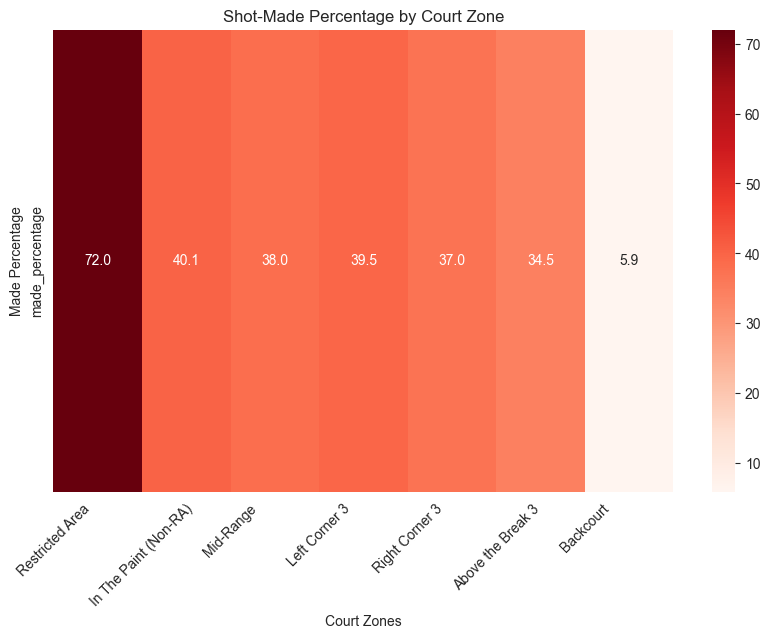

In [17]:
# Filter necessary columns
df_new = df[['BASIC_ZONE', 'SHOT_MADE']]

# Calculate shot-made percentage for each zone
zone_stats = df_new.groupby('BASIC_ZONE').agg(
    total_shots=('SHOT_MADE', 'count'),
    made_shots=('SHOT_MADE', 'sum')
)
zone_stats['made_percentage'] = (zone_stats['made_shots'] / zone_stats['total_shots']) * 100

# Define court zones for plotting
zones = [
    "Restricted Area",
    "In The Paint (Non-RA)",
    "Mid-Range",
    "Left Corner 3",
    "Right Corner 3",
    "Above the Break 3",
    "Backcourt"
]

# Ensure all zones are accounted for
zone_stats = zone_stats.reindex(zones)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(zone_stats[['made_percentage']].T, annot=True, fmt=".1f", cmap="Reds", cbar=True)
plt.title("Shot-Made Percentage by Court Zone")
plt.xlabel("Court Zones")
plt.ylabel("Made Percentage")
plt.xticks(ticks=range(len(zones)), labels=zones, rotation=45)
plt.show()

**This chart highlights LeBron James's shot efficiency by court zones:**

Restricted Area Dominance (72%): The highest shot-making percentage is in the restricted area, showcasing LeBron's elite ability to finish at the rim.

Decline in Efficiency Outside the Paint: In the non-restricted paint area (40.1%) and mid-range (38%), efficiency drops, reflecting a common trend of lower-percentage shots from these zones.

Three-Point Variability:

The corners (39.5% for left, 37% for right) are more efficient than "above the break" threes (34.5%), aligning with league trends due to shorter corner distances.
Backcourt Attempts (5.9%): Minimal efficiency in the backcourt likely represents end-of-clock desperation shots.

This data suggests LeBron's scoring is most efficient near the basket.

# 3. Data Preprocessing and Feature Engineering

In [18]:
cat_features = ['POSITION_GROUP', 'POSITION', 'ACTION_TYPE','SHOT_TYPE','ZONE_NAME','BASIC_ZONE',"ZONE_RANGE"]

# Deeper dives into unique values of categorical data
for col in cat_features:
    print(f"\nUnique values in '{col}':")
    print(df[col].value_counts())


Unique values in 'POSITION_GROUP':
POSITION_GROUP
F    25693
G     3618
Name: count, dtype: int64

Unique values in 'POSITION':
POSITION
SF    17697
PF     7996
PG     2126
SG     1492
Name: count, dtype: int64

Unique values in 'ACTION_TYPE':
ACTION_TYPE
Jump Shot                      11950
Driving Layup Shot              3394
Layup Shot                      2849
Fadeaway Jump Shot              1138
Pullup Jump shot                 904
                               ...  
Running Finger Roll Shot           3
Running Bank Hook Shot             3
Turnaround Finger Roll Shot        2
Step Back Bank Jump Shot           2
Putback Reverse Dunk Shot          1
Name: count, Length: 67, dtype: int64

Unique values in 'SHOT_TYPE':
SHOT_TYPE
2PT Field Goal    22387
3PT Field Goal     6924
Name: count, dtype: int64

Unique values in 'ZONE_NAME':
ZONE_NAME
Center               16554
Left Side Center      3972
Left Side             3249
Right Side Center     2998
Right Side            2489
Back Co

In [19]:
df.drop(columns=["SEASON_2","TEAM_ID","TEAM_NAME","PLAYER_ID","PLAYER_NAME","GAME_DATE","GAME_ID","HOME_TEAM","AWAY_TEAM","EVENT_TYPE","ZONE_ABB"], inplace=True)
df['TIME_LEFT'] = df['MINS_LEFT'] * 60 + df['SECS_LEFT']

Dropping redundant columns and instead of using Mins left to quarter end and Secs left to that minute ends, We decided to use secs left to quarter and as new TIME_LEFT feature. Of coure we will normalize it later.

In [20]:
def group_basic_zone(zone):
    if zone <8:
        return "Close"
    elif 8<=zone and zone<16:
        return "Mid"
    elif 16<=zone and zone<24:
        return "Mid-Long"
    elif 24<=zone:
        return "Long"     
    return "Other"

df['DIST_GROUP'] = df['SHOT_DISTANCE'].apply(group_basic_zone)

This function divides shooting distances into 4 different categories. We thought this will be a useful categorization for our model (to be encoded later, of course).

In [21]:
# After the new time feature, we are dropping the old ones
df.drop(columns=["MINS_LEFT","SECS_LEFT"],inplace=True)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29311 entries, 258 to 4135774
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SEASON_1        29311 non-null  object 
 1   POSITION_GROUP  29311 non-null  object 
 2   POSITION        29311 non-null  object 
 3   SHOT_MADE       29311 non-null  bool   
 4   ACTION_TYPE     29311 non-null  object 
 5   SHOT_TYPE       29311 non-null  object 
 6   BASIC_ZONE      29311 non-null  object 
 7   ZONE_NAME       29311 non-null  object 
 8   ZONE_RANGE      29311 non-null  object 
 9   LOC_X           29311 non-null  float64
 10  LOC_Y           29311 non-null  float64
 11  SHOT_DISTANCE   29311 non-null  int64  
 12  QUARTER         29311 non-null  int64  
 13  TIME_LEFT       29311 non-null  int64  
 14  DIST_GROUP      29311 non-null  object 
dtypes: bool(1), float64(2), int64(3), object(9)
memory usage: 3.4+ MB


In [23]:
print(f"\nUnique values in 'New Distance Zones':")
print(df["DIST_GROUP"].value_counts())


Unique values in 'New Distance Zones':
DIST_GROUP
Close       13346
Long         6162
Mid-Long     6152
Mid          3651
Name: count, dtype: int64


For the encoding of categorical features, we decided to use different kinds of encoding methods. The main reason why we choose this path is that categorical features are not same with each other. But what does that mean? For example, SHOT_TYPE is an ordinal feature but ZONE_NAME is a Nominal one. There is some exceptions of course, e.g. ACTION_TYPE is nominal but it has so many unique actions for to be one hot encode.


Information:

To prevent biases from being introduced, One-Hot Encoding is preferable for nominal data (where there is no inherent order among categories). Label encoding, however, might be more appropriate for ordinal data (where categories naturally have an order). The effect of dimensionality should also be taken into account.

In [24]:
# Encoders
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
label_encoder = LabelEncoder()

# 1. SEASON_1: Sadece integer formatına dönüştür (zaten integer, gerek yok)
df['SEASON_1'] = df['SEASON_1'].astype(int)

# 2. POSITION_GROUP: Binary Encoding (F = 1, Other = 0)
df['POSITION_GROUP'] = df['POSITION_GROUP'].apply(lambda x: 1 if x == 'F' else 0)

# 3. POSITION: OneHotEncoder kullanımı
position_encoded = one_hot_encoder.fit_transform(df[['POSITION']])
position_columns = [f"POSITION_{cat}" for cat in one_hot_encoder.categories_[0]]
df[position_columns] = position_encoded
df.drop(columns=['POSITION'], inplace=True)

# 4. ACTION_TYPE: Rare Categories Threshold + Label Encoder
action_counts = df['ACTION_TYPE'].value_counts()
threshold = 100
df['ACTION_TYPE'] = df['ACTION_TYPE'].apply(lambda x: x if action_counts[x] > threshold else 'Other')

df['ACTION_TYPE'] = label_encoder.fit_transform(df['ACTION_TYPE'])  # Label Encoding

# 5. SHOT_TYPE: Binary Encode
df['SHOT_TYPE'] = label_encoder.fit_transform(df['SHOT_TYPE'])  # 2PT Field Goal = 0, 3PT Field Goal = 1

# 6. ZONE_NAME: OneHotEncoder ile
zone_encoded = one_hot_encoder.fit_transform(df[['ZONE_NAME']])
zone_columns = [f"ZONE_{cat}" for cat in one_hot_encoder.categories_[0]]
df[zone_columns] = zone_encoded
df.drop(columns=['ZONE_NAME'], inplace=True)

# 7. BASIC_ZONE: OneHotEncoder
basic_zone_encoded = one_hot_encoder.fit_transform(df[['BASIC_ZONE']])
basic_zone_columns = [f"BASIC_{cat}" for cat in one_hot_encoder.categories_[0]]
df[basic_zone_columns] = basic_zone_encoded
df.drop(columns=['BASIC_ZONE'], inplace=True)

# RANGES
basic_zone_encoded = one_hot_encoder.fit_transform(df[['DIST_GROUP']])
basic_zone_columns = [f"DIST_{cat}" for cat in one_hot_encoder.categories_[0]]
df[basic_zone_columns] = basic_zone_encoded
df.drop(columns=['ZONE_RANGE'], inplace=True)

# Final DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 29311 entries, 258 to 4135774
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SEASON_1                     29311 non-null  int64  
 1   POSITION_GROUP               29311 non-null  int64  
 2   SHOT_MADE                    29311 non-null  bool   
 3   ACTION_TYPE                  29311 non-null  int64  
 4   SHOT_TYPE                    29311 non-null  int64  
 5   LOC_X                        29311 non-null  float64
 6   LOC_Y                        29311 non-null  float64
 7   SHOT_DISTANCE                29311 non-null  int64  
 8   QUARTER                      29311 non-null  int64  
 9   TIME_LEFT                    29311 non-null  int64  
 10  DIST_GROUP                   29311 non-null  object 
 11  POSITION_PF                  29311 non-null  float64
 12  POSITION_PG                  29311 non-null  float64
 13  POSITION_SF      

In [25]:
print(df.sample(1))
df.drop(columns=['DIST_GROUP'], inplace=True)

        SEASON_1  POSITION_GROUP  SHOT_MADE  ACTION_TYPE  SHOT_TYPE  LOC_X  \
957357      2008               1      False           16          0   -0.0   

        LOC_Y  SHOT_DISTANCE  QUARTER  TIME_LEFT  ... BASIC_Backcourt  \
957357   5.55              0        4        280  ...             0.0   

        BASIC_In The Paint (Non-RA)  BASIC_Left Corner 3  BASIC_Mid-Range  \
957357                          0.0                  0.0              0.0   

        BASIC_Restricted Area  BASIC_Right Corner 3  DIST_Close  DIST_Long  \
957357                    1.0                   0.0         1.0        0.0   

        DIST_Mid  DIST_Mid-Long  
957357       0.0            0.0  

[1 rows x 32 columns]


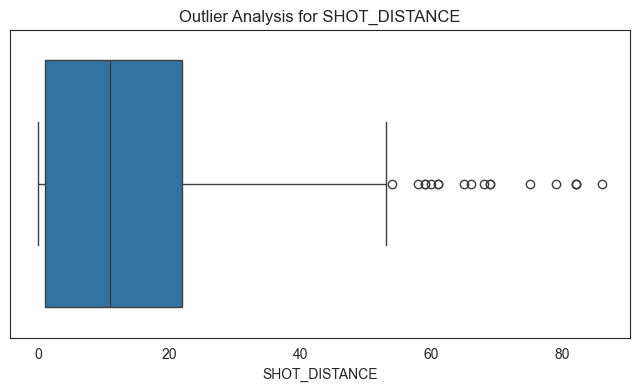

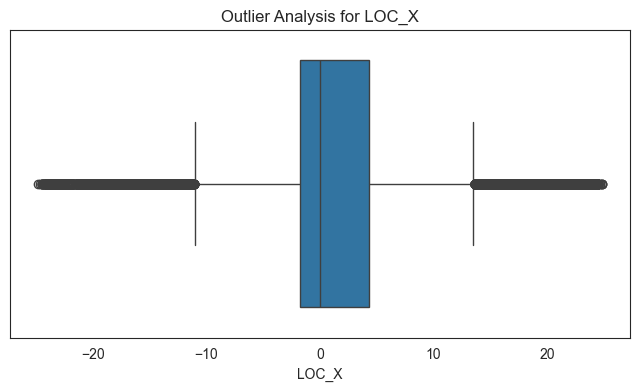

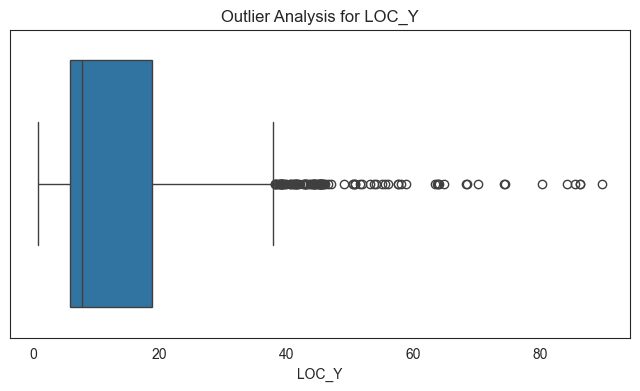

SHOT_DISTANCE      18
LOC_X            7514
LOC_Y              94
dtype: int64


In [26]:
# Numerical Cols for outlier analysis
numerical_cols = ['SHOT_DISTANCE', 'LOC_X', 'LOC_Y']

for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x=col)
    plt.title(f'Outlier Analysis for {col}')
    plt.show()


# IQR Method
Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Setting Boundiries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Outliers filtering and visualization
outliers = (df[numerical_cols] < lower_bound) | (df[numerical_cols] > upper_bound)
print(outliers.sum()) 

We can't consider these LOC_X values as outliers. Since most of the shots are dunk the 3 pointers are labeled as outlier but it is wrong.

And there is no significant outliers in LOC_Y and SHOT_DIST columns

**Normalization**

In [27]:
# Min max scaler 
scaler = MinMaxScaler()


# We calculated the angle between the lebron and the basket but it wasn't a use feature so We didn't use it but 
# I thought that this was a cool approach so here is the codes in a comment line

#X['ANGLE'] = np.abs(np.rad2deg(np.arctan2(X['LOC_X'], X['LOC_Y'])))
#X = X.drop(columns=['LOC_X', 'LOC_Y'])

# Normalization
df['SHOT_MADE'] = df['SHOT_MADE'].astype(int)
df= pd.DataFrame(scaler.fit_transform(df), columns=df.columns)


X = df.drop(columns=["SHOT_MADE"])
y = df["SHOT_MADE"]



y = y.astype(int)  # Convert target to integer if not already

print(X.info())
print(y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29311 entries, 0 to 29310
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SEASON_1                     29311 non-null  float64
 1   POSITION_GROUP               29311 non-null  float64
 2   ACTION_TYPE                  29311 non-null  float64
 3   SHOT_TYPE                    29311 non-null  float64
 4   LOC_X                        29311 non-null  float64
 5   LOC_Y                        29311 non-null  float64
 6   SHOT_DISTANCE                29311 non-null  float64
 7   QUARTER                      29311 non-null  float64
 8   TIME_LEFT                    29311 non-null  float64
 9   POSITION_PF                  29311 non-null  float64
 10  POSITION_PG                  29311 non-null  float64
 11  POSITION_SF                  29311 non-null  float64
 12  POSITION_SG                  29311 non-null  float64
 13  ZONE_Back Court 

# 4. Perdictive Modeling

## 4.1 Logistic Regression

In [31]:
# Sample data split into X and y as given, let's ensure indices align
# Ensure the correct format for y (from the provided example)
y = y.astype(int)  # Convert target to integer if not already

# Train-test split (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the logistic regression model
logistic_model = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
logistic_model.fit(X_train, y_train)

# Predictions
y_pred = logistic_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

accuracy, precision, recall, f1, conf_matrix, class_report

print(class_report)

              precision    recall  f1-score   support

           0       0.62      0.78      0.69      2895
           1       0.72      0.54      0.62      2968

    accuracy                           0.66      5863
   macro avg       0.67      0.66      0.65      5863
weighted avg       0.67      0.66      0.65      5863



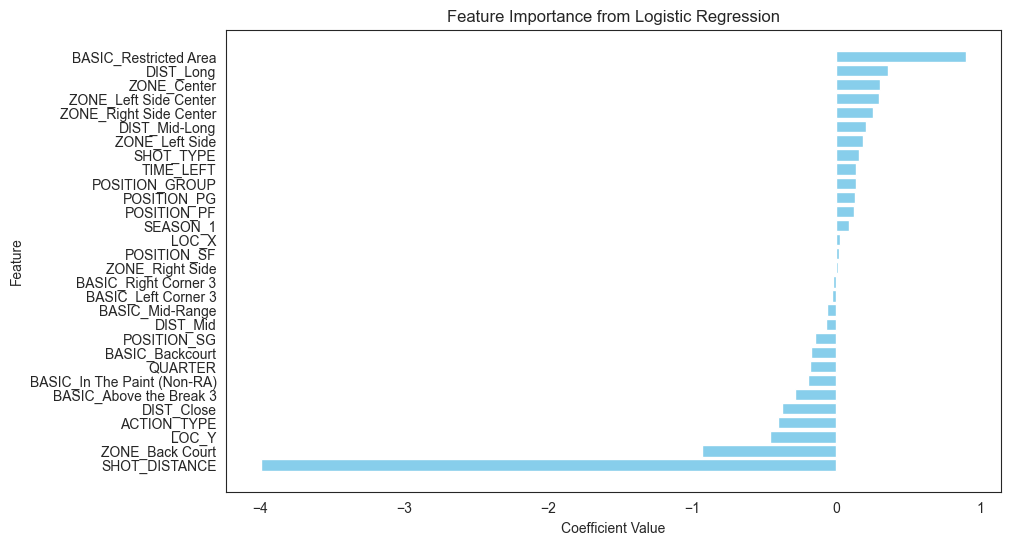

Top Positive Features:
                   Feature  Coefficient
24   BASIC_Restricted Area     0.898357
27               DIST_Long     0.356842
14             ZONE_Center     0.304930
16   ZONE_Left Side Center     0.296561
18  ZONE_Right Side Center     0.251687
29           DIST_Mid-Long     0.208473
15          ZONE_Left Side     0.182233
3                SHOT_TYPE     0.159354
8                TIME_LEFT     0.137141
1           POSITION_GROUP     0.134955

Top Negative Features:
                        Feature  Coefficient
12                  POSITION_SG    -0.147410
20              BASIC_Backcourt    -0.178620
7                       QUARTER    -0.180272
21  BASIC_In The Paint (Non-RA)    -0.198349
19      BASIC_Above the Break 3    -0.284260
26                   DIST_Close    -0.377627
2                   ACTION_TYPE    -0.408638
5                         LOC_Y    -0.459671
13              ZONE_Back Court    -0.933349
6                 SHOT_DISTANCE    -3.989887


In [32]:
# Get feature importance (coefficients) from logistic regression
coefficients = logistic_model.coef_[0]
feature_names = X.columns

# Create a DataFrame for easier visualization
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance from Logistic Regression')
plt.gca().invert_yaxis()
plt.show()

# Display top 10 most impactful features
print("Top Positive Features:")
print(feature_importance.head(10))
print("\nTop Negative Features:")
print(feature_importance.tail(10))

**Top Positive Features (High Impact on Shot Success)**

BASIC_Restricted Area (Coefficient: 0.898357):

Shots in the restricted area have the highest positive influence on success, which aligns with basketball fundamentals: close-range shots (like layups or dunks) are easier to make.

DIST_Long (Coefficient: 0.356842):

Interestingly, this indicates that some long-distance shots might have a positive impact.

ZONE_Center, ZONE_Left Side Center, ZONE_Right Side Center:

These zones also show strong positive contributions, suggesting that shots from central areas are generally more successful.

SHOT_TYPE (2PT shots):

As expected, two-point field goals have a higher likelihood of success compared to three-point shots.
Top Negative Features (Hindering Shot Success)

SHOT_DISTANCE (Coefficient: -3.988887):

As expected, longer distances strongly reduce the probability of shot success. This reaffirms the difficulty of making long-range shots.

ZONE_Back Court:

Backcourt shots are extremely low-probability events (usually desperation shots at the end of the clock).

LOC_Y and BASIC_Above the Break 3:

LOC_Y may indicate positional disadvantage (being far from optimal zones).
BASIC_Above the Break 3 reflects the general difficulty of long-range three-point shots.

## 4.2 XGBoost

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
xgb_model = XGBClassifier().fit(X_train,y_train)

predictions = xgb_model.predict(X_test)

actuals = y_test

print("Confusion Matrix :")
print(confusion_matrix(actuals, predictions))

print("\nPrecision Score :")      
print(precision_score(actuals, predictions) )

print("\nAccuracy Score :")            
print(accuracy_score(actuals, predictions))


Confusion Matrix :
[[2131  764]
 [1216 1752]]

Precision Score :
0.6963434022257552

Accuracy Score :
0.6622889305816135


In [34]:
# Train-test split (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the XGBoost Classifier
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')

# Train the model on the training set
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
class_report_xgb = classification_report(y_test, y_pred_xgb)

accuracy_xgb, precision_xgb, recall_xgb, f1_xgb, conf_matrix_xgb, class_report_xgb

print(class_report_xgb)

              precision    recall  f1-score   support

           0       0.64      0.74      0.68      2895
           1       0.70      0.59      0.64      2968

    accuracy                           0.66      5863
   macro avg       0.67      0.66      0.66      5863
weighted avg       0.67      0.66      0.66      5863



In [35]:
# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_child_weight': [1, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma':[0,0.1]
}
# Initialize XGBoost Classifier
xgb = XGBClassifier(random_state=42, eval_metric='logloss')

gsearch1 = GridSearchCV(estimator = xgb, param_grid = param_grid, scoring=['accuracy', 'roc_auc'], refit='roc_auc',cv=3)
gsearch1.fit(X_train ,y_train)

scores = pd.DataFrame(gsearch1.cv_results_).sort_values('rank_test_roc_auc')

print('Best model')
print('***********')
print('Mean validation accuracy: ', scores.iloc[0, :]['mean_test_accuracy'])
print('Mean validation AUC: ', gsearch1.best_score_, '\n')
print('Best hyperparameters')
print('***********')
for param, val in gsearch1.best_params_.items():
    print(param + ':', val)

Best model
***********
Mean validation accuracy:  0.680058000682361
Mean validation AUC:  0.7303539844537092 

Best hyperparameters
***********
colsample_bytree: 0.8
gamma: 0
learning_rate: 0.1
max_depth: 5
min_child_weight: 5
n_estimators: 50
subsample: 1.0


## 4.3 Random Forest 

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred_rf = rf_model.predict(X_test)

# Evaluate the Random Forest model
rf_accuracy = accuracy_score(y_test, y_test_pred_rf)
rf_classification_report = classification_report(y_test, y_test_pred_rf)
rf_confusion_matrix = confusion_matrix(y_test, y_test_pred_rf)

# Print Random Forest results
print("Random Forest Test Accuracy:", rf_accuracy)
print("Random Forest Classification Report:\n", rf_classification_report)
print("Random Forest Confusion Matrix:\n", rf_confusion_matrix)


Random Forest Test Accuracy: 0.6675763261129115
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.80      0.70      2895
           1       0.73      0.54      0.62      2968

    accuracy                           0.67      5863
   macro avg       0.68      0.67      0.66      5863
weighted avg       0.68      0.67      0.66      5863

Random Forest Confusion Matrix:
 [[2316  579]
 [1370 1598]]


In [37]:
param_grid = {
    'n_estimators': [100],
    'criterion': ['gini'],
    'max_depth': [5, 10, 15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5, 10, 15],
    'max_features': ['sqrt']
}

grid_search_cv = GridSearchCV(
    estimator = RandomForestClassifier(n_jobs = -1, random_state = 42),
    param_grid = param_grid,
    scoring = ['accuracy', 'roc_auc'],
    n_jobs = -1,
    refit = 'roc_auc',
    cv = 5,
    verbose = 3,
    return_train_score = True    
).fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [38]:
scores = pd.DataFrame(grid_search_cv.cv_results_).sort_values('rank_test_roc_auc')

print('Best model')
print('***********')
print('Mean validation accuracy: ', scores.iloc[0, :]['mean_test_accuracy'])
print('Mean validation AUC: ', grid_search_cv.best_score_, '\n')
print('Best hyperparameters')
print('***********')
for param, val in grid_search_cv.best_params_.items():
    print(param + ':', val)

Best model
***********
Mean validation accuracy:  0.673063491608769
Mean validation AUC:  0.7219230660551904 

Best hyperparameters
***********
criterion: gini
max_depth: 15
max_features: sqrt
min_samples_leaf: 10
min_samples_split: 2
n_estimators: 100


# 5. Conclusion

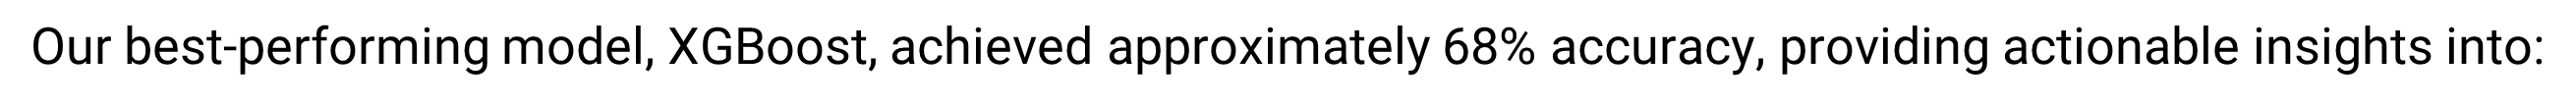

- Shot Patterns
- Player Strategy Optimization
- Game Decision-Making

| Method                              | Accuracy |
|-------------------------------------|----------|
| Linear Regression                   | 0.6605   |
| XGBoost (without parameter tuning)  | 0.6625   |
| XGBoost (best parameters)           | 0.6805   |
| Random Forest                       | 0.6710   |
| Random Forest (best parameters)     | 0.6730   |

## 5.1 Just one of dozens of unsuccessful operations and attempts

In [ ]:
"""# Check for outliers in numerical columns
numerical_columns = ['LOC_X', 'LOC_Y', 'SHOT_DISTANCE', 'TIME_LEFT']

# Calculate IQR for each column
outlier_bounds = {}
for col in numerical_columns:
    Q1 = df_2[col].quantile(0.25)
    Q3 = df_2[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_bounds[col] = (lower_bound, upper_bound)

# Identify outliers
outliers = {col: df_2[(df_2[col] < bounds[0]) | (df_2[col] > bounds[1])] for col, bounds in outlier_bounds.items()}

# Summary of outliers
outliers_summary = {col: len(data) for col, data in outliers.items()}

# Encoding categorical features
categorical_columns = ['POSITION_GROUP', 'POSITION', 'ACTION_TYPE', 'SHOT_TYPE', 'BASIC_ZONE', 'ZONE_NAME']
encoded_df = pd.get_dummies(df_2, columns=categorical_columns, drop_first=True)

print(encoded_df.head())

# Normalize numerical features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
encoded_df[numerical_columns] = scaler.fit_transform(encoded_df[numerical_columns])

# Display results
outliers_summary, encoded_df.head()"""

In [ ]:
"""# 1. Group BASIC_ZONE into higher-level categories
def group_basic_zone(zone):
    if zone in ["Restricted Area", "In The Paint (Non-RA)"]:
        return "Close Range"
    elif zone == "Mid-Range":
        return "Mid-Range"
    elif zone in ["Above the Break 3", "Left Corner 3", "Right Corner 3", "Backcourt"]:
        return "Long Range"
    return "Other"

df_2['ZONE_GROUP'] = df_2['BASIC_ZONE'].apply(group_basic_zone)

# 2. Group ACTION_TYPE into High, Moderate, and Low Success
def group_action_type(action):
    if "Dunk" in action or "Layup" in action or "Tip" or  "Roll" in action:
        return "High Success"
    elif "Hook" in action or "Floater" in action:
        return "Moderate Success"
    elif "Jump" in action or "Fadeaway" in action or "Step Back" in action:
        return "Low Success"
    return "Other"

df_2['ACTION_GROUP'] = df_2['ACTION_TYPE'].apply(group_action_type)

# 3. Create binary features for group membership
df_2['IS_CLOSE_RANGE'] = df_2['ZONE_GROUP'] == "Close Range"
df_2['IS_HIGH_SUCCESS'] = df_2['ACTION_GROUP'] == "High Success"

# Convert binary columns to integer for modeling
df_2['IS_CLOSE_RANGE'] = df_2['IS_CLOSE_RANGE'].astype(int)
df_2['IS_HIGH_SUCCESS'] = df_2['IS_HIGH_SUCCESS'].astype(int)

# Check the updated DataFrame


#df_2 = df_2.drop(columns=["POSITION_GROUP","POSITION","SHOT_TYPE","SEASON_1"])
df_2_updated_head = df_2.sample(10)

df_2_updated_head"""

In [ ]:
"""from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# 1. Encode remaining categorical variables (if any)
categorical_columns = [ 'ZONE_GROUP', 'ACTION_GROUP']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Apply OneHotEncoder to categorical columns
encoded_data = encoder.fit_transform(df_2[categorical_columns])

# Create a DataFrame for the encoded features
encoded_columns = encoder.get_feature_names_out(categorical_columns)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_columns, index=df_2.index)

# Drop the original categorical columns and merge the encoded features
df_encoded = df_2.drop(columns=categorical_columns).join(encoded_df)

# 2. Normalize numerical features
numerical_columns = ['LOC_X', 'LOC_Y', 'SHOT_DISTANCE', 'TIME_LEFT']
scaler = MinMaxScaler()

# Apply MinMaxScaler to numerical columns
df_encoded[numerical_columns] = scaler.fit_transform(df_encoded[numerical_columns])

# Check the final DataFrame structure
df_encoded_info = df_encoded.info()
df_encoded_head = df_encoded.head()

df_encoded_info, df_encoded_head"""

In [ ]:
"""from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd

print(df_encoded.columns)

# Apply one-hot encoding to these columns
#df_encoded = df_encoded.drop(columns=["ACTION_TYPE","ZONE_NAME","BASIC_ZONE"])

print(df_encoded.head())

# Separate features and target variable
X = df_encoded.drop(columns=["SHOT_MADE"])  # Features
y = df_encoded["SHOT_MADE"].astype(int)    # Target

# Split into training, testing, and validation sets (70% train, 20% test, 10% validation)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.333, random_state=42, stratify=y_temp)

# Initialize logistic regression model
logistic_model = LogisticRegression(random_state=42, max_iter=10000)

# Train the model on the training set
logistic_model.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred = logistic_model.predict(X_test)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)

# Print evaluation results
print("Test Accuracy:", test_accuracy)
print("Classification Report:\n", test_classification_report)
print("Confusion Matrix:\n", test_confusion_matrix)

"""


In [ ]:
"""# Get feature importance (coefficients) from logistic regression
coefficients = logistic_model.coef_[0]
feature_names = X.columns

# Create a DataFrame for easier visualization
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance from Logistic Regression')
plt.gca().invert_yaxis()
plt.show()

# Display top 10 most impactful features
print("Top Positive Features:")
print(feature_importance.head(10))
print("\nTop Negative Features:")
print(feature_importance.tail(10))"""

In [ ]:
"""X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
xgb_model = XGBClassifier().fit(X_train,y_train)

predictions = xgb_model.predict(X_test)

actuals = y_test

print(confusion_matrix(actuals, predictions))
print(precision_score(actuals, predictions) )"""

In [ ]:
"""# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [1, 3, 5,10],
    'learning_rate': [0.00001, 0.0001, 0.001],
    'max_depth': [4, 5],
    'min_child_weight':[0.0001,0.001,0.01]
}

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_child_weight': [1, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma':[0,0.1]
}

parameters_for_testing = {
    'min_child_weight': [1, 5, 10, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [5,10,50, 100, 200],
    'max_depth': [3, 5, 7]
}

# Initialize XGBoost Classifier
xgb = XGBClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

gsearch1 = GridSearchCV(estimator = xgb, param_grid = parameters_for_testing, scoring='accuracy',cv=3)
gsearch1.fit(X_train ,y_train)

print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)  
"""